In [3]:
import numpy as np
import pandas as pd
from scipy import sparse

from tqdm import tqdm
tqdm.pandas()
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

from nltk.tag import pos_tag
from nltk.tokenize import word_tokenize

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO, TraceMeanField_ELBO
from pyro.optim import Adam, ClippedAdam

from datetime import datetime
import json
from collections import defaultdict

import os

In [4]:
OUT_DIR = '/mnt/swordfish-pool2/ndeas/prob_models/results2/' #'/burg/nlp/users/zfh2000/style_results'

DATA_SRC = '/mnt/swordfish-pool2/ndeas/prob_models/data/enron_processed.json' #'/burg/nlp/users/zfh2000/enron_processed.json'
SPLITS_PATH = '/mnt/swordfish-pool2/ndeas/prob_models/data/authors_splits.json' #'/burg/home/zfh2000/styletopicmodeling/scripts/authors_splits.json'
SYNTHETIC_SRC = '/mnt/swordfish-pool2/ndeas/prob_models/data/gpt_4_enron_processed.json' #'/burg/nlp/users/zfh2000/gpt_4_enron_processed.json'

# NICK: files have been uploaded here: https://drive.google.com/drive/folders/1uF9GWEGe4aqSeo2MlachAWR9bTHsJq1q?usp=sharing
# ['formality','irony', 'sentences', 'punc_tags', 'pos_bigrams', 'morph_tags', 'pos', 'casing', 'question',  'passive', 'emotion_task', 'sentiment_task', 'emoji_task']
# NICK: Unsure which of of these features we should include!

META_FEATURES = ['pos_bigrams','formality','emoji_task', 'casing','punc_tags', 'sentiment_task']
EXPERIMENT_NAME = '_'.join(META_FEATURES)

BATCH_SIZE = 128
NUM_WORKERS = 2 #8

LR = 1e3
BETAS = (0.99, 0.999)
EPS   = 1e-8
CLIP_NORM = 10.
ADAM_ARGS = {'lr': LR, 'betas': BETAS, 'eps': EPS, 'clip_norm': CLIP_NORM}

DEVICE = torch.device('cuda:0')

NUM_TOPICS = 10 #10 #20 # NICK totally subject to changes
NUM_STYLES = 10  #20
HIDDEN_DIM = 128
DROPOUT    = 0 #0.2

THETA_PRIOR_DIST = 'gaussian'
THETA_PRIOR_LOC = 0.
THETA_PRIOR_SCALE = 1.

KAPPA_PRIOR_DIST = 'gaussian' #'laplace'
KAPPA_PRIOR_LOC = 0.
KAPPA_PRIOR_SCALE = 5 #10 #1.

STYLE_TOPIC_LINK = 'none' #'kappa_doc' #'none'

NUM_EPOCHS = 50 #100

MAX_DF=0.7
MIN_DF=20

date = datetime.now().strftime("%Y-%m-%d_%H_%M_%S")
info = {
    'experiment_name': EXPERIMENT_NAME,
    'num_topics': NUM_TOPICS,
    'num_styles': NUM_STYLES,
    'hidden_dim': HIDDEN_DIM,
    'dropout': DROPOUT,
    'theta_prior_dist': THETA_PRIOR_DIST,
    'theta_prior_loc': THETA_PRIOR_LOC,
    'theta_prior_scale': THETA_PRIOR_SCALE,
    'kappa_prior_dist': KAPPA_PRIOR_DIST,
    'kappa_prior_loc': KAPPA_PRIOR_LOC,
    'kappa_prior_scale': KAPPA_PRIOR_SCALE,
    'style_topic_link': STYLE_TOPIC_LINK,
    'num_epochs': NUM_EPOCHS,
    'date': date,
    'lr': LR,
    'betas': BETAS,
    'eps': EPS,
    'batch_size': BATCH_SIZE,
    'clip_norm': CLIP_NORM,
    'num_workers': NUM_WORKERS,
    'device': DEVICE.type,
    'meta_features': META_FEATURES,
    'DATA_SRC': DATA_SRC,
    'SPLITS_PATH': SPLITS_PATH,
    'SYNTHETIC_SRC': SYNTHETIC_SRC,
    'MAX_DF': MAX_DF,
    'MIN_DF': MIN_DF,

}
PATH = os.path.join(OUT_DIR, EXPERIMENT_NAME, date)
os.makedirs(PATH, exist_ok=True)
with open(os.path.join(PATH, 'info.json'), 'w') as f:
    json.dump(info, f, indent=4)

DATA_DIR_PATH = os.path.join(OUT_DIR,EXPERIMENT_NAME, f'maxdf{MAX_DF}_mindf{MIN_DF}_DATA')


# Data Setup 

## Data Processing 

In [5]:
import json
import pickle
from preprocess import clean_up_features, get_possible_values, extract_features

if not os.path.exists(DATA_DIR_PATH):
    with open(DATA_SRC, 'r') as in_file:
        data = json.load(in_file)
    
    with open(SYNTHETIC_SRC, 'r') as in_file:
       synthetic_data = json.load(in_file)
    
    # print(synthetic_data[:1])
    
    data = data + synthetic_data
    
    with open(SPLITS_PATH, 'r') as in_file:
        SPLITS = json.load(in_file)
    
    # data.head(2)
    for x in data:
        clean_up_features(x)
        
    print(data[:1])
    
    meta_feature_to_names = {}
    
    for key in META_FEATURES:
        meta_feature_to_names[key] = get_possible_values(data, key)
    
    extracted_features = [extract_features(d, meta_feature_to_names) for d in data]
    
    # extracted_features[2]
    
    training = []
    holdout = []

    author_labels = {'training':[], 'holdout':[]}

    raw_text = {'training':[], 'holdout':[]}
    
    authors = [d['info']['from'] for d in data]
    texts = [d['text'] for d in data]
    for author, t, d  in zip(authors, texts, extracted_features):
        if author.startswith('gpt') or author in SPLITS['train']:
            training.append(d)
            author_labels['training'].append(author)
            raw_text['training'].append(t)
            
    
        else:
            holdout.append(d)
            author_labels['holdout'].append(author)
            assert author in SPLITS['test']
            raw_text['holdout'].append(t)
    
    
    vectorizer = CountVectorizer(max_df=MAX_DF, min_df=MIN_DF, stop_words='english')
    vectorizer.fit([d['text'] for d in training])
    
    bows = {}

    meta_vectorized = {}
    
    for split_name, data_split in zip(['training','holdout'], [training, holdout]):
         bows[split_name] = vectorizer.transform([d['text'] for d in data_split])
         meta_vectorized[split_name] = {}
         for key in tqdm(sorted(data_split[0].keys())):
            if key in ['text']: continue
            meta_vectorized[split_name][key] = sparse.csr_matrix(np.stack([d[key] for d in data_split]))
            assert(bows[split_name].shape[0] == meta_vectorized[split_name][key].shape[0])

    os.makedirs(DATA_DIR_PATH, exist_ok=False)
    pickle.dump(vectorizer, open(os.path.join(DATA_DIR_PATH,"vectorizer.pickle"), "wb"))
    pickle.dump(bows, open(os.path.join(DATA_DIR_PATH,"bows.pickle"), "wb"))
    pickle.dump(meta_vectorized, open(os.path.join(DATA_DIR_PATH,"meta_vectorized.pickle"), "wb"))
    
    json.dump(raw_text, open(os.path.join(DATA_DIR_PATH,"raw_text.json"), "w"))
    json.dump(author_labels, open(os.path.join(DATA_DIR_PATH,"authors_json.json"), "w"))
    json.dump(meta_feature_to_names, open(os.path.join(DATA_DIR_PATH,"meta_feature_to_names.json"), "w"))
    
else:
    print(f"LOADING FROM {DATA_DIR_PATH}")
    with open(os.path.join(DATA_DIR_PATH, 'bows.pickle'), 'rb') as in_file:
        bows = pickle.load(in_file)
        
    with open(os.path.join(DATA_DIR_PATH, 'meta_vectorized.pickle'), 'rb') as in_file:
        meta_vectorized = pickle.load(in_file)    
    
    with open(os.path.join(DATA_DIR_PATH,"vectorizer.pickle"), 'rb') as in_file:
        vectorizer = pickle.load(in_file)
    

LOADING FROM /mnt/swordfish-pool2/ndeas/prob_models/results2/pos_bigrams_formality_emoji_task_casing_punc_tags_sentiment_task/maxdf0.7_mindf20_DATA


### Summary 

In [6]:
NUM_DOCS   = bows['training'].shape[0]
VOCAB_SIZE = bows['training'].shape[1]
META_SIZE  = {k:v.shape[1] for k,v in meta_vectorized['training'].items()}
IDX_TO_TERM = {v:k for k,v in vectorizer.vocabulary_.items()}

In [7]:
print(f'BOW Dims: {bows["training"].shape}')
print(f'META Dims: {META_SIZE}')

BOW Dims: (66668, 3098)
META Dims: {'casing': 3, 'emoji_task': 20, 'formality': 2, 'pos_bigrams': 324, 'punc_tags': 20, 'sentiment_task': 3}


## Dataset

In [8]:
class DocMetaData(Dataset):
    
    def __init__(self, bows, metas, 
                 split_halves = False, perc_obs = 0.5,
                 dtype = np.float32):
        self.bows = bows
        self.metas = metas
        
        self.split_halves = split_halves
        self.perc_obs = perc_obs
        
        self.dtype = dtype
        
        if self.split_halves:
            bowh_counts = (bows.toarray().sum(axis= -1) * self.perc_obs).astype(int).tolist()
    
            self.bows_h1, self.bows_h2 = [], []
            for bow, bcount in zip(bows, bowh_counts):
                h1 = bow.toarray().copy().squeeze()
                for i in range(bcount):
                    idx = np.random.choice(h1.squeeze().nonzero()[0])
                    h1[idx] -= 1
                h2 = (bow.toarray() - h1).squeeze()

                self.bows_h1.append(h1)
                self.bows_h2.append(h2)
            
            self.bows_h1 = sparse.csr_matrix(self.bows_h1)
            self.bows_h2 = sparse.csr_matrix(self.bows_h2)
        
    def __len__(self):
        return self.bows.shape[0]
    
    def __getitem__(self, idx):
        
        bow = self.bows[idx].toarray().astype(self.dtype)[0]
        
        meta = {key:self.metas[key][idx].toarray().astype(self.dtype)[0] for key in self.metas}
        
        batch = {
            'bow': bow,
            'meta': meta,
        }
        
        if self.split_halves:
            batch['bow_h1'] = self.bows_h1[idx].toarray().astype(self.dtype)[0]
            batch['bow_h2'] = self.bows_h2[idx].toarray().astype(self.dtype)[0]
        
        return batch

In [9]:
# from prodslda_cls import DocMetaData

In [10]:
dataset = DocMetaData(bows['training'], meta_vectorized['training'])
eval_dataset = DocMetaData(bows['holdout'], meta_vectorized['holdout'], split_halves = True)

In [11]:
dl = DataLoader(dataset, batch_size = BATCH_SIZE, num_workers = NUM_WORKERS, shuffle=True)
eval_dl = DataLoader(eval_dataset, batch_size = BATCH_SIZE, num_workers = NUM_WORKERS, shuffle=True)

In [31]:
test_ = next(iter(dl))
for k, v in test_.items():
    if isinstance(v, dict):
        print(k)
        for k1, v1 in v.items():
             print('\t'+k1, v1.shape)
    else:
        print(k, v.shape)
            
    # print(f'{k:7s}: {str(v.shape):25s} {str(v.dtype):25s}')

bow torch.Size([128, 3098])
meta
	casing torch.Size([128, 3])
	emoji_task torch.Size([128, 20])
	formality torch.Size([128, 2])
	pos_bigrams torch.Size([128, 324])
	punc_tags torch.Size([128, 20])
	sentiment_task torch.Size([128, 3])


# Model Definition 

## ProdSLDA 

In [13]:
# from prodslda_cls import ProdSLDA

In [64]:
class DocMetaData(Dataset):
    
    def __init__(self, bows, metas, dtype = np.float32):
        self.bows = bows
        self.metas = metas
        
        self.dtype = dtype
        
    def __len__(self):
        return self.bows.shape[0]
    
    def __getitem__(self, idx):
        
        bow = self.bows[idx].toarray().astype(self.dtype)[0]
        
        meta = {key:self.metas[key][idx].toarray().astype(self.dtype)[0] for key in self.metas}
        
        batch = {
            'bow': bow,
            'meta': meta,
        }
        
        return batch

class GeneralEncoder(nn.Module):
    
    def __init__(self, size_dict, num_styles, hidden, dropout, eps = 1e-10):
        super().__init__()
        
        self.eps = eps

        self.sizes = size_dict
        
        self.drop = nn.Dropout(dropout)  # to avoid component collapse
        
        # self.fc1_doc = nn.Linear(vocab_size, hidden)
        # self.fc1_meta = nn.Linear(meta_size, hidden)

        self.features = sorted(size_dict.keys())
        self.fc1s = nn.ModuleDict({feature:nn.Linear(self.sizes[feature], hidden) for feature in self.features})
        self.fc2 = nn.Linear(len(self.features) * hidden, hidden)
        self.fcmu = nn.Linear(hidden, num_styles)
        self.fclv = nn.Linear(hidden, num_styles)

        self.bnmu = nn.BatchNorm1d(num_styles, affine=False)  # to avoid component collapse
        self.bnlv = nn.BatchNorm1d(num_styles, affine=False)  # to avoid component collapse

    def forward(self, inputs): #inputs_doc, inputs_meta):
        assert isinstance(inputs, dict)
        first_hiddens = []
        for _, feature in enumerate(self.features):
            first_hiddens.append(F.softplus(self.fc1s[feature](inputs[feature])))
        
        h = torch.hstack(first_hiddens)
        h = F.softplus(self.fc2(h))
        h = self.drop(h)
        # μ and Σ are the outputs
        logkappa_loc = self.bnmu(self.fcmu(h))
        logkappa_logvar = self.bnlv(self.fclv(h))
        logkappa_scale = self.eps + (0.5 * logkappa_logvar).exp()  # Enforces positivity
        return logkappa_loc, logkappa_scale

class Decoder(nn.Module):
    # Base class for the decoder net, used in the model
    def __init__(self, vocab_size, num_topics, dropout):
        super().__init__()
        self.beta = nn.Linear(num_topics, vocab_size, bias=False)
        self.bn = nn.BatchNorm1d(vocab_size, affine=False)
        self.drop = nn.Dropout(dropout)

    def forward(self, inputs):
        inputs = self.drop(inputs)
        # the output is σ(βθ)
        return self.bn(self.beta(inputs))
    
class MetaDocDecoder(nn.Module):
    # Base class for the decoder net, used in the model
    def __init__(self, vocab_size, num_topics, num_styles, dropout):
        super().__init__()
        self.t_beta = nn.Linear(num_topics, vocab_size, bias=False)
        self.s_beta = nn.Linear(num_styles, vocab_size, bias=False)
        self.t_bn = nn.BatchNorm1d(vocab_size, affine=False)
        self.s_bn = nn.BatchNorm1d(vocab_size, affine=False)
        self.drop = nn.Dropout(dropout)

    def forward(self, inputs_doc, inputs_meta):
        inputs_doc  = self.drop(inputs_doc)
        dist_t = self.t_bn(self.t_beta(inputs_doc))
        
        if inputs_meta is None:
            return dist_t
        else:
            inputs_meta = self.drop(inputs_meta)
            dist_s = self.s_bn(self.s_beta(inputs_meta))
            
            return 0.5 * (dist_t + dist_s)

class ProdSLDA(nn.Module):
    
    PRIOR_DISTS  = {'gaussian': dist.Normal,
                    'laplace': dist.Laplace,
                   }
    TK_LINKS     = ('none', # Model style and documents independently
                    'kappa_doc', # Allow kappa to effect word distributions
                    'kappa_doc_style', # Allow kappa to effect word distributions and sampled words to effect style
                   )
    
    def __init__(self, vocab_size, meta_sizes, num_topics, num_styles, hidden, dropout, 
                 theta_prior_dist = 'gaussian', theta_prior_loc = 0., theta_prior_scale = 1.,
                 kappa_prior_dist = 'laplace', kappa_prior_loc = 0., kappa_prior_scale = 1.,
                 style_topic_link = 'none',
                 eps = 1e-10):
        super().__init__()
        
        # Global model variables
        self.vocab_size = vocab_size
        self.meta_sizes = meta_sizes
        self.num_topics = num_topics
        self.num_styles = num_styles
        self.hidden     = hidden
        self.dropout    = dropout

        self.meta_features = sorted(self.meta_sizes.keys())
        
        self.eps = eps
        
        # Theta Prior
        if theta_prior_dist not in ProdSLDA.PRIOR_DISTS.keys():
            raise ValueError(f'Theta prior {theta_prior_dist} not yet implemented. Must be one of {", ".join(ProdSLDA.PRIOR_DISTS.keys())}')
        self.theta_prior_dist = theta_prior_dist
        
        self.theta_prior_scale = theta_prior_scale
        self.theta_prior_loc = theta_prior_loc
        
        # Kappa Prior
        if kappa_prior_dist not in ProdSLDA.PRIOR_DISTS.keys():
            raise ValueError(f'Kappa prior {kappa_prior_dist} not yet implemented. Must be one of {", ".join(ProdSLDA.PRIOR_DISTS.keys())}')
        self.kappa_prior_dist = kappa_prior_dist
        
        self.kappa_prior_scale = kappa_prior_scale
        self.kappa_prior_loc = kappa_prior_loc
        
        
        # Document style linking
        self.style_topic_link = style_topic_link
        
        if self.style_topic_link not in ProdSLDA.TK_LINKS:
            raise ValueError(f'Link {self.style_topic_link} not yet implemented. Must be one of {", ".join(ProdSLDA.TK_LINKS)}')
        elif self.style_topic_link == 'none':
            # Independent modeling of style and topic, all normal encoder/decoders
            
            self.encoder = GeneralEncoder({'doc':vocab_size}, num_topics, hidden, dropout, self.eps)
            self.decoder = Decoder(vocab_size, num_topics, dropout)
            self.style_encoder = GeneralEncoder(meta_sizes, num_styles, hidden, dropout, self.eps)
            self.style_decoder = nn.ModuleDict({feature: Decoder(meta_s, num_styles, dropout) for feature, meta_s in meta_sizes.items()})
            
        elif self.style_topic_link == 'kappa_doc':
            # raise NotImplementedError()
            # Doc influences kappa encoding, style encoder takes in doc
            self.encoder = GeneralEncoder({'doc':vocab_size}, num_styles, hidden, dropout, self.eps)
            self.style_encoder = GeneralEncoder({'doc':vocab_size, **meta_sizes}, num_styles, hidden, dropout, self.eps)

            self.decoder = MetaDocDecoder(vocab_size=vocab_size, num_topics=num_topics, num_styles=num_styles, dropout=dropout)
            self.style_decoder = nn.ModuleDict({feature: Decoder(meta_s, num_styles, dropout) for feature, meta_s in meta_sizes.items()})


    def model(self, docs, metas):
        pyro.module("decoder", self.decoder)
        pyro.module("style_decoder", self.style_decoder)
        
        with pyro.plate("documents", docs.shape[0]):
            # Dirichlet prior 𝑝(𝜃|𝛼) is replaced by a logistic-normal distribution
            logtheta_loc = docs.new_zeros((docs.shape[0], self.num_topics)) * self.theta_prior_loc
            logtheta_scale = docs.new_ones((docs.shape[0], self.num_topics)) * self.theta_prior_scale
            logkappa_loc = docs.new_zeros((docs.shape[0], self.num_styles)) * self.kappa_prior_loc
            logkappa_scale = docs.new_ones((docs.shape[0], self.num_styles)) * self.kappa_prior_scale
            
            if self.style_topic_link == 'kappa_doc':
                logtheta_s_loc = docs.new_zeros((docs.shape[0], self.num_topics)) * self.theta_prior_loc
                logtheta_s_scale = docs.new_ones((docs.shape[0], self.num_topics)) * self.theta_prior_scale
                
                logtheta_s = pyro.sample(
                    "logtheta_s", ProdSLDA.PRIOR_DISTS[self.theta_prior_dist](logtheta_s_loc, logtheta_s_scale).to_event(1))
                
                theta_s = F.softmax(logtheta_s, -1)
            
            logtheta = pyro.sample(
                "logtheta", ProdSLDA.PRIOR_DISTS[self.theta_prior_dist](logtheta_loc, logtheta_scale).to_event(1))
            logkappa = pyro.sample(
                "logkappa", ProdSLDA.PRIOR_DISTS[self.kappa_prior_dist](logkappa_loc, logkappa_scale).to_event(1))
            
            theta = F.softmax(logtheta, -1)
            kappa = F.softmax(logkappa, -1)

            if self.style_topic_link == 'none':
                word_logits = self.decoder(theta)
            elif self.style_topic_link == 'kappa_doc':
                word_logits = self.decoder(theta, kappa)
                
            style_logits = {feature:self.style_decoder[feature](kappa) for feature in self.meta_features}

            total_count = int(docs.sum(-1).max())
            pyro.sample(
                'obs_doc',
                dist.Multinomial(total_count, logits = word_logits),
                obs=docs
            )

            for feature in self.meta_features:
                total_s_count = int(metas[feature].sum(-1).max())
                pyro.sample(
                    'obs_meta_'+feature,
                    dist.Multinomial(total_s_count, logits = style_logits[feature]),
                    obs=metas[feature]
                )

    def guide(self, docs, metas):
        pyro.module("encoder", self.encoder)
        pyro.module("style_encoder", self.style_encoder)
            
        with pyro.plate("documents", docs.shape[0]):
            # Dirichlet prior 𝑝(𝜃|𝛼) is replaced by a logistic-normal distribution,
            # where μ and Σ are the encoder network outputs
            
            if self.style_topic_link == 'none':
                logtheta_loc, logtheta_scale = self.encoder({'doc':docs})
                logkappa_loc, logkappa_scale = self.style_encoder(metas)

            elif self.style_topic_link == 'kappa_doc':
                # raise NotImplementedError()
                # logtheta_loc, logtheta_scale, logkappa_d_loc, logkappa_d_scale = self.encoder({'doc':docs, **metas})
                logtheta_loc, logtheta_scale  = self.encoder({'doc':docs})
                logkappa_loc, logkappa_scale = self.style_encoder({'doc':docs, **metas})

                # NICK what was the point of d_loc and d_scale? Shoudln't we be generating one set of kappas from both features?
                
                # Average theta loc from document and style
                # logkappa_loc = 0.5 * (logkappa_loc + logkappa_d_loc) 
                # logkappa_scale = 0.5 * (logkappa_scale + logkappa_d_scale)
            
            # Sample logtheta/logkappa from guide
            logtheta = pyro.sample(
                "logtheta", ProdSLDA.PRIOR_DISTS[self.theta_prior_dist](logtheta_loc, logtheta_scale).to_event(1))
            logkappa = pyro.sample(
                "logkappa", ProdSLDA.PRIOR_DISTS[self.kappa_prior_dist](logkappa_loc, logkappa_scale).to_event(1))

        # return logtheta, logkappa
            

    def beta_document(self):
        if self.style_topic_link == 'none':
            return {'beta_topic':self.decoder.beta.weight.cpu().detach().T}
        elif self.style_topic_link == 'kappa_doc':
            return {
                'beta_topic':self.decoder.t_beta.weight.cpu().detach().T,
                'beta_style':self.decoder.s_beta.weight.cpu().detach().T,
            }
        else:
            raise NotImplementedError()
            
    def beta_meta(self):
        # beta matrix elements are the weights of the FC layer on the decoder
        # return self.decoder.beta.weight.cpu().detach().T
        retval = {}
        for key, layer in self.style_decoder.items():
            retval[key] = layer.beta.weight.cpu().detach().T
        return retval
    
    def reconstruct_doc(self, inputs, use_style = True):
        
        if self.style_topic_link == 'none':
            logtheta_loc, _  = self.encoder({'doc':inputs['bow_h1']})
            theta = F.softmax(logtheta_loc, -1)
            word_logits = self.decoder(theta)
            
        elif self.style_topic_link == 'kappa_doc':
            logtheta_loc, _  = self.encoder({'doc':inputs['bow_h1']})
            theta = F.softmax(logtheta_loc, -1)
            
            if use_style:
                logkappa_loc, _ = self.style_encoder({'doc':inputs['bow_h1'], **inputs['meta']})
                kappa = F.softmax(logkappa_loc, -1)
            else:
                kappa = None
            
            word_logits = self.decoder(theta, kappa)
        
        recon = F.softmax(word_logits, dim = -1)
        
        return recon
    
    def reconstruct_style(self, inputs):
        '''
            Reconstruct style/metadata from document alone by zeroing out metadata.
        '''
        
        zero_meta = {k:torch.zeros_like(inputs['meta'][k]) for k in inputs['meta'].keys()}
        
        logkappa_loc, _ = self.style_encoder({'doc':inputs['bow'], **zero_meta})

        kappa = F.softmax(logkappa_loc, dim = -1)
        
        s_recon = {feature:self.style_decoder[feature](kappa) for feature in self.meta_features}
        s_recon = {feature:F.softmax(s_recon[feature], dim = -1) for feature in self.meta_features}
        
        return s_recon
    
    def doc_reconstruct_ce(self, inputs, use_style = True):
    
        recon = self.reconstruct_doc(inputs, use_style = use_style)

        total_count = inputs['bow_h2'].sum()

        ce = (-inputs['bow_h2']*torch.log(recon)).sum().cpu().item()

        return ce, total_count
    
    def style_reconstruct_ce(self, inputs):
        
        s_recon = ProdSLDA.reconstruct_style(self, inputs)
        
        style_ce, total_s_count = 0, 0
        for feature in self.meta_features:
            total_s_count += inputs['meta'][feature].sum()
            
            style_ce += (-inputs['meta'][feature]*torch.log(s_recon[feature])).sum().cpu().item()
        
        return style_ce, total_s_count
            

# Reconstruct Perplexity 

In [15]:
prod_slda = torch.load('/mnt/swordfish-pool2/ndeas/prob_models/results2/pos_bigrams_formality_emoji_task_casing_punc_tags_sentiment_task/2023-12-15_00_30_51/model_epoch50_5439.549745559692.pt').to(DEVICE)

In [124]:
total_ce, total_count = 0., 0.
for batch in tqdm(eval_dl):
    for key in batch.keys():
        if isinstance(batch[key], dict):
            for key2 in batch[key].keys():
                batch[key][key2] = batch[key][key2].to(DEVICE)
        else:
            batch[key] = batch[key].to(DEVICE)
    
    ce, count = reconstruct_ce(prod_slda, batch)
    total_ce += ce
    total_count += count

100%|██████████| 179/179 [00:12<00:00, 14.36it/s]


In [125]:
print(f'PERP: {torch.exp(total_ce/total_count).item():.4f}')

PERP: 3104.6968


# Model Fitting 

In [13]:
# NUM_TOPICS = 10
# # BATCH_SIZE = 
# # NUM_STYLES = 2
# # DROPOUT    = 0.
# HIDDEN_DIM = 256
# LR = 1e3

# THETA_PRIOR_SCALE = 1
# # KAPPA_PRIOR_SCALE = 3

# CLIP_NORM = 10

## Setup

In [14]:
prod_slda = ProdSLDA(
    vocab_size = VOCAB_SIZE,
    meta_sizes  = META_SIZE,
    num_topics = NUM_TOPICS, num_styles = NUM_STYLES, 
    hidden = HIDDEN_DIM, dropout = DROPOUT, 
    theta_prior_dist = THETA_PRIOR_DIST, 
    theta_prior_loc = THETA_PRIOR_LOC, theta_prior_scale = THETA_PRIOR_SCALE,
    kappa_prior_dist = KAPPA_PRIOR_DIST, 
    kappa_prior_loc = KAPPA_PRIOR_LOC, kappa_prior_scale = KAPPA_PRIOR_SCALE,
    style_topic_link = STYLE_TOPIC_LINK,
).to(DEVICE)

print(prod_slda.beta_document())
print(prod_slda.beta_meta())


{'beta_topic': tensor([[ 0.1991, -0.1363, -0.1472,  ...,  0.1322,  0.2636, -0.0783],
        [-0.2153,  0.2501, -0.1350,  ..., -0.0792,  0.1818,  0.1772],
        [ 0.1964, -0.2804,  0.0250,  ...,  0.1309,  0.1166, -0.2686],
        ...,
        [-0.0902,  0.0421,  0.2616,  ..., -0.1802,  0.2770,  0.0874],
        [ 0.1353,  0.3139, -0.1316,  ..., -0.0847, -0.0984, -0.1902],
        [ 0.3023,  0.0318, -0.1055,  ...,  0.1219, -0.0238,  0.0458]])}
{'casing': tensor([[-0.0006, -0.1709, -0.2364],
        [-0.2986, -0.1544,  0.2920],
        [ 0.1431, -0.0717,  0.1599],
        [ 0.1246,  0.0029,  0.0759],
        [ 0.0959, -0.0642,  0.0878],
        [-0.2332,  0.2444, -0.2629],
        [-0.1812, -0.0995,  0.0694],
        [-0.2636, -0.2692,  0.1475],
        [ 0.0458,  0.0275, -0.0629],
        [-0.1145,  0.0815,  0.2279]]), 'emoji_task': tensor([[-0.1511, -0.1578, -0.0612,  0.1374, -0.2138, -0.1289, -0.0504, -0.1511,
         -0.2411,  0.3024,  0.0727,  0.2787,  0.2465,  0.0232, -0.0429, 

## Training 

In [15]:
pyro.clear_param_store()
prod_slda.train()
print(DEVICE)
_

cuda:0


''

In [16]:
optim = pyro.optim.ClippedAdam(ADAM_ARGS)

svi = SVI(
    pyro.poutine.scale(prod_slda.model, BATCH_SIZE/len(dl.dataset)),
    pyro.poutine.scale(prod_slda.model, BATCH_SIZE/len(dl.dataset)),
    optim,
    loss = TraceMeanField_ELBO()
)

In [17]:
print(pyro.poutine.trace(prod_slda.guide).get_trace(test_['bow'].to(DEVICE), {k:v.to(DEVICE) for k,v in test_['meta'].items()}).format_shapes())


                             Trace Shapes:            
                              Param Sites:            
                 encoder$$$fc1s.doc.weight 128 3098   
                   encoder$$$fc1s.doc.bias      128   
                      encoder$$$fc2.weight 128  128   
                        encoder$$$fc2.bias      128   
                     encoder$$$fcmu.weight  10  128   
                       encoder$$$fcmu.bias       10   
                     encoder$$$fclv.weight  10  128   
                       encoder$$$fclv.bias       10   
        style_encoder$$$fc1s.casing.weight 128    3   
          style_encoder$$$fc1s.casing.bias      128   
    style_encoder$$$fc1s.emoji_task.weight 128   20   
      style_encoder$$$fc1s.emoji_task.bias      128   
     style_encoder$$$fc1s.formality.weight 128    2   
       style_encoder$$$fc1s.formality.bias      128   
   style_encoder$$$fc1s.pos_bigrams.weight 128  324   
     style_encoder$$$fc1s.pos_bigrams.bias      128   
     style

In [18]:
total_epochs = 0

In [19]:
NUM_EPOCHS = 50

In [68]:
def batch_to_device(batch, device):
    bow = batch['bow'].to(device)
    meta = {k:v.to(device) for k,v in batch['meta'].items()}
    
    new_batch = {'bow': bow, 'meta': meta}
    
    if 'bow_h1' in batch.keys() and 'bow_h2' in batch.keys():
        bow_h1 = batch['bow_h1'].to(device)
        bow_h2 = batch['bow_h2'].to(device)
        
        new_batch['bow_h1'] = bow_h1
        new_batch['bow_h2'] = bow_h2
    
    return new_batch

In [20]:
train_elbo = []
val_elbo = []

print("---TRAINING---")
for epoch in range(NUM_EPOCHS):
    
    epoch_elbo = 0.
    prod_slda.train()
    for batch in tqdm(dl):
        
        batch = batch_to_device(batch, DEVICE)
        
        bow = batch['bow']
        meta = batch['meta']
        
        epoch_elbo += svi.step(bow, meta)

    eval_elbo = 0
    prod_slda.eval()
    with torch.no_grad():
        for batch in tqdm(eval_dl):
            
            batch = batch_to_device(batch)
            
            bow = batch['bow']
            meta = batch['meta']
    
            eval_elbo += svi.evaluate_loss(bow, meta)
    
        
    print(f'Epoch {epoch}: {epoch_elbo:.3f}')
    print(f'Epoch {epoch}: Eval: {eval_elbo:.3f}')
    
    train_elbo.append(epoch_elbo)
    val_elbo.append(eval_elbo)
    total_epochs +=1

---TRAINING---


  0%|          | 0/521 [00:00<?, ?it/s]/home/ndeas/envs/test_env/lib/python3.8/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'obs_meta_emoji_task', 'obs_meta_formality', 'obs_meta_pos_bigrams', 'obs_meta_casing', 'obs_meta_sentiment_task', 'obs_meta_punc_tags', 'obs_doc'}
  warnings.warn(
100%|██████████| 179/179 [00:12<00:00, 14.00it/s]


Epoch 0: 17970.592
Epoch 0: Eval: 6013.945


100%|██████████| 179/179 [00:12<00:00, 13.77it/s]


Epoch 1: 17963.382
Epoch 1: Eval: 6006.773


100%|██████████| 179/179 [00:22<00:00,  8.10it/s]


Epoch 2: 17940.314
Epoch 2: Eval: 6005.278


100%|██████████| 179/179 [00:15<00:00, 11.34it/s]


Epoch 3: 17919.088
Epoch 3: Eval: 6000.394


100%|██████████| 179/179 [00:12<00:00, 14.45it/s]


Epoch 4: 17893.937
Epoch 4: Eval: 5985.915


100%|██████████| 179/179 [00:11<00:00, 16.06it/s]


Epoch 5: 17866.533
Epoch 5: Eval: 5984.000


100%|██████████| 179/179 [00:15<00:00, 11.67it/s]


Epoch 6: 17835.479
Epoch 6: Eval: 5964.155


100%|██████████| 179/179 [00:14<00:00, 12.07it/s]


Epoch 7: 17769.914
Epoch 7: Eval: 5936.017


100%|██████████| 179/179 [00:14<00:00, 12.65it/s]


Epoch 8: 17720.876
Epoch 8: Eval: 5911.568


100%|██████████| 179/179 [00:11<00:00, 15.00it/s]


Epoch 9: 17650.103
Epoch 9: Eval: 5893.457


100%|██████████| 179/179 [00:11<00:00, 15.55it/s]


Epoch 10: 17563.911
Epoch 10: Eval: 5857.679


100%|██████████| 179/179 [00:11<00:00, 15.52it/s]


Epoch 11: 17468.618
Epoch 11: Eval: 5835.173


100%|██████████| 179/179 [00:11<00:00, 15.24it/s]


Epoch 12: 17344.274
Epoch 12: Eval: 5786.883


100%|██████████| 179/179 [00:11<00:00, 15.69it/s]


Epoch 13: 17224.919
Epoch 13: Eval: 5733.703


100%|██████████| 179/179 [00:11<00:00, 15.31it/s]


Epoch 14: 17080.785
Epoch 14: Eval: 5677.069


100%|██████████| 179/179 [00:11<00:00, 15.97it/s]


Epoch 15: 16928.795
Epoch 15: Eval: 5630.107


100%|██████████| 179/179 [00:11<00:00, 15.29it/s]


Epoch 16: 16796.902
Epoch 16: Eval: 5581.431


100%|██████████| 179/179 [00:11<00:00, 15.60it/s]


Epoch 17: 16667.599
Epoch 17: Eval: 5562.878


100%|██████████| 179/179 [00:12<00:00, 14.63it/s]


Epoch 18: 16578.726
Epoch 18: Eval: 5528.892


100%|██████████| 179/179 [00:12<00:00, 13.85it/s]


Epoch 19: 16506.918
Epoch 19: Eval: 5505.629


100%|██████████| 179/179 [00:12<00:00, 14.87it/s]


Epoch 20: 16438.109
Epoch 20: Eval: 5489.253


100%|██████████| 179/179 [00:13<00:00, 13.00it/s]


Epoch 21: 16398.285
Epoch 21: Eval: 5473.627


100%|██████████| 179/179 [00:11<00:00, 16.13it/s]


Epoch 22: 16366.799
Epoch 22: Eval: 5474.234


100%|██████████| 179/179 [00:10<00:00, 16.50it/s]


Epoch 23: 16343.297
Epoch 23: Eval: 5458.933


100%|██████████| 179/179 [00:12<00:00, 14.49it/s]


Epoch 24: 16321.000
Epoch 24: Eval: 5454.762


100%|██████████| 179/179 [00:32<00:00,  5.54it/s]


Epoch 25: 16306.552
Epoch 25: Eval: 5452.688


100%|██████████| 179/179 [00:39<00:00,  4.58it/s]


Epoch 26: 16297.938
Epoch 26: Eval: 5449.164


100%|██████████| 179/179 [00:29<00:00,  6.08it/s]


Epoch 27: 16289.799
Epoch 27: Eval: 5443.886


100%|██████████| 179/179 [00:32<00:00,  5.57it/s]


Epoch 28: 16286.235
Epoch 28: Eval: 5444.094


100%|██████████| 179/179 [00:41<00:00,  4.31it/s]


Epoch 29: 16282.168
Epoch 29: Eval: 5443.586


100%|██████████| 179/179 [00:29<00:00,  5.97it/s]


Epoch 30: 16278.648
Epoch 30: Eval: 5444.456


100%|██████████| 179/179 [00:37<00:00,  4.78it/s]


Epoch 31: 16279.935
Epoch 31: Eval: 5444.533


100%|██████████| 179/179 [00:32<00:00,  5.57it/s]


Epoch 32: 16279.418
Epoch 32: Eval: 5443.090


100%|██████████| 179/179 [01:04<00:00,  2.76it/s]


Epoch 33: 16278.235
Epoch 33: Eval: 5443.817


100%|██████████| 179/179 [00:29<00:00,  5.97it/s]


Epoch 34: 16276.408
Epoch 34: Eval: 5443.307


100%|██████████| 179/179 [00:11<00:00, 15.21it/s]


Epoch 35: 16277.287
Epoch 35: Eval: 5444.209


100%|██████████| 179/179 [00:11<00:00, 15.51it/s]


Epoch 36: 16275.490
Epoch 36: Eval: 5442.510


100%|██████████| 179/179 [00:11<00:00, 16.00it/s]


Epoch 37: 16275.297
Epoch 37: Eval: 5441.645


100%|██████████| 179/179 [00:11<00:00, 15.24it/s]


Epoch 38: 16274.825
Epoch 38: Eval: 5441.549


100%|██████████| 179/179 [00:11<00:00, 15.51it/s]


Epoch 39: 16273.300
Epoch 39: Eval: 5440.169


100%|██████████| 179/179 [00:12<00:00, 14.29it/s]


Epoch 40: 16273.595
Epoch 40: Eval: 5442.306


100%|██████████| 179/179 [00:12<00:00, 13.78it/s]


Epoch 41: 16274.655
Epoch 41: Eval: 5440.602


100%|██████████| 179/179 [00:11<00:00, 15.15it/s]


Epoch 42: 16273.662
Epoch 42: Eval: 5440.521


100%|██████████| 179/179 [00:13<00:00, 13.61it/s]


Epoch 43: 16271.106
Epoch 43: Eval: 5441.959


100%|██████████| 179/179 [00:10<00:00, 17.51it/s]


Epoch 44: 16273.035
Epoch 44: Eval: 5441.670


100%|██████████| 179/179 [00:13<00:00, 13.57it/s]


Epoch 45: 16270.617
Epoch 45: Eval: 5440.828


100%|██████████| 179/179 [00:12<00:00, 14.40it/s]


Epoch 46: 16271.109
Epoch 46: Eval: 5440.434


100%|██████████| 179/179 [00:12<00:00, 14.78it/s]


Epoch 47: 16271.466
Epoch 47: Eval: 5439.123


100%|██████████| 179/179 [00:11<00:00, 15.23it/s]


Epoch 48: 16269.560
Epoch 48: Eval: 5440.630


100%|██████████| 179/179 [00:11<00:00, 15.84it/s]

Epoch 49: 16270.258
Epoch 49: Eval: 5437.915


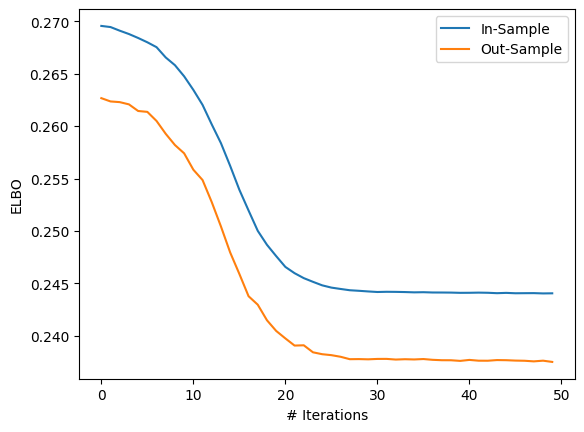

In [25]:
plt.plot(range(len(train_elbo)), [e/len(dl.dataset) for e in train_elbo], label = 'In-Sample')
plt.plot(range(len(val_elbo)), [e/len(eval_dl.dataset) for e in val_elbo], label = 'Out-Sample')

plt.legend()
plt.xlabel('# Iterations')
plt.ylabel('ELBO')

plt.savefig('loss_plot_indep.png', dpi = 600, facecolor = None)


# Examine Topics 

In [49]:
tbeta = prod_slda.beta_meta()['formality']

In [50]:
top_terms = (-tbeta).sort().indices[:,:10].numpy()
top_weights = -(-tbeta).sort().values[:,:10]

In [51]:
top_weights

tensor([[ -11084.0586,  -20374.3613],
        [  37257.0391,   26151.0312],
        [-142690.5625, -149046.4219],
        [ -82477.7109,  -82660.1016],
        [ -16607.1289,  -30520.9824],
        [   5274.2495,  -10392.5977],
        [ 117328.8281,  116500.9297],
        [ 180576.1875,  166553.7344],
        [  -1815.5582,   -5198.7021],
        [  20806.4004,    6787.3848]])

In [52]:
top_words = defaultdict(list)
for i, term_l in enumerate(top_terms):
    top_words['topic ' + str(i)] = [IDX_TO_TERM[term_id] for term_id in term_l]

In [53]:
pd.DataFrame(top_words).T

,0,1
topic 0,000,00
topic 1,000,00
topic 2,000,00
topic 3,000,00
topic 4,000,00
topic 5,000,00
topic 6,000,00
topic 7,000,00
topic 8,000,00
topic 9,000,00


In [582]:
idx_1 = vectorizer.vocabulary_['paper']
idx_2 = vectorizer.vocabulary_['regards']

In [550]:
(bows['training'][:, idx_1] >= 1).sum(), (bows['training'][:, idx_2] >= 1).sum()

(113, 1079)

In [551]:
((bows['training'][:, idx_1] + bows['training'][:, idx_2]).toarray().squeeze() >= 2).sum()

9

In [54]:
def top_beta_document(model, vectorizer, top_k=20):
    betas_document = model.beta_document()
    features_to_betas = {}
    idx_to_name = {v:k for k,v in vectorizer.vocabulary_.items()}
    for feature, logits in betas_document.items():
        features_to_betas[feature] = []
        num_features = logits.shape[0]
        top_results = torch.topk(logits, top_k, dim=-1)
        
        ids = top_results.indices.cpu().numpy()
        values = top_results.values.cpu().numpy()
        
        for i in tqdm(range(num_features)):
            features_to_betas[feature].append({'values':values[i], 'top':[idx_to_name[idx] for idx in ids[i]]})
                
    return features_to_betas

def top_beta_meta(model, meta_feature_to_names, top_k=20):
    betas_metas = model.beta_meta()
    features_to_betas = {}
    for feature, logits in betas_metas.items():
        idx_to_name = {i:k for i,k in enumerate(meta_feature_to_names[feature])}
        features_to_betas[feature] = []
        num_features = logits.shape[0]
        top_results = torch.topk(logits, top_k, dim=-1)
        ids = top_results.indices.cpu().numpy()
        values = top_results.values.cpu().numpy()
        for i in tqdm(range(num_features)):
            features_to_betas[feature].append({'values':values[i], 'top':[idx_to_name[idx] for idx in ids[i]]})
        
    return features_to_betas 

In [55]:
top_words_per_latent = top_beta_document(prod_slda, vectorizer,  top_k=20)
top_meta_per_latent = top_beta_meta(prod_slda, meta_feature_to_names, top_k=20)

print('Document Term Info')
for latent, top in top_words_per_latent.items():
    print(f'\t{latent} ({len(top)}):')
    for i, results in enumerate(top):
        print(f'\t\t {latent} ({i}):\n{results["top"]}')
        print()

print('Meta Var Info')
for latent, top in top_meta_per_latent.items():

    print(f'\t{latent} ({len(top)}):')
    for i, results in enumerate(top):
        print(f'\t\t {latent} ({i}):\n{results["top"]}')
        print()

100%|██████████| 10/10 [00:00<00:00, 28767.52it/s]


NameError: name 'meta_feature_to_names' is not defined

In [27]:
for key, value in prod_slda.beta_meta().items():
    print(key, F.softmax(value,-1))

pos_bigrams tensor([[0.0031, 0.0031, 0.0028,  ..., 0.0043, 0.0032, 0.0028],
        [0.0031, 0.0037, 0.0031,  ..., 0.0047, 0.0034, 0.0025],
        [0.0031, 0.0039, 0.0028,  ..., 0.0042, 0.0032, 0.0029],
        [0.0029, 0.0031, 0.0022,  ..., 0.0027, 0.0023, 0.0033],
        [0.0025, 0.0027, 0.0018,  ..., 0.0022, 0.0019, 0.0033]])


In [56]:
path = os.path.join(PATH, f'model_epoch{total_epochs}_{val_elbo[-1]}.pt')
prod_slda.eval()
torch.save(prod_slda, path)
# pyro.clear_param_store()
# prod_slda = torch.load(path)
print(f'Saved to {path}')

Saved to /mnt/swordfish-pool2/ndeas/prob_models/results2/pos_bigrams_formality_emoji_task_casing_punc_tags_sentiment_task/2023-12-15_00_23_06/model_epoch50_5437.914863586426.pt


In [109]:
prod_slda.beta_meta()

{'pos_bigrams': tensor([[-1.8304e+00, -1.8904e+00, -2.0618e+00,  ..., -1.5975e+00,
          -2.6415e+00, -1.9489e+00],
         [ 7.8684e-01,  1.0342e+00,  1.1435e+00,  ...,  1.0513e+00,
           1.1998e+00,  1.0992e+00],
         [ 8.8633e-01,  1.1214e+00,  1.3023e+00,  ...,  1.2147e+00,
           1.2440e+00,  1.1934e+00],
         [-4.2701e-01, -2.5076e-01, -3.2173e-01,  ..., -1.0346e-01,
          -5.0079e-01, -2.3791e-01],
         [-2.4423e-03,  1.2616e-01,  1.4202e-01,  ...,  2.4994e-01,
           1.5193e-02,  2.2705e-01]])}